# Introduction
This is a dashboard which showcases some of the most important data regarding sales from the mockup tech shop. <br>
The database contains information about current suppliers, products and customers as well as information about sales from a month period. <br>

<br>

### Connecting to Database

In [22]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import numpy as np


In [23]:
DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'Zotac-B\SQLEXPRESS'
DATABASE_NAME = 'ShopInventoryDB'

connection_string = 'Driver={SQL Server};Server=' + SERVER_NAME + ';Database=' + DATABASE_NAME + ';'


In [24]:
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

<br>

### Database tables lookup

In [110]:
def Show_table(table_name, rows):
    switch={
        'Customers':'SELECT TOP ' + str(rows) + '* FROM Customers',
        'Products' : 'SELECT TOP ' + str(rows) + ' * FROM Products',
        'Orders' : 'SELECT TOP ' + str(rows) + ' * FROM Orders',
        'OrderItems': 'SELECT TOP ' + str(rows) + ' * FROM OrderItems',
        'Suppliers' : 'SELECT TOP ' + str(rows) + ' * FROM Suppliers'
      }
    query = switch.get(table_name, "SELECT 'no table selected'")
    df = pd.read_sql_query(query, engine)
    print(df.to_string(index=False))

name = "OrderItems" #input table name here, or leave a blank string
rows = 15  #input number of rows to show here
Show_table(name, rows)


 order_item_id  order_id  product_id  quantity_ordered  unit_price
             1         1           5                 1       39.99
             2         1           9                 1       39.99
             3         2          14                 1       69.99
             4         2           8                 1      119.99
             5         3           3                 1      199.99
             6         4           6                 1       19.99
             7         4          10                 1      299.99
             8         5           4                 1        9.99
             9         5           7                 1       79.99
            10         6           1                 1       29.99
            11         6          12                 1       29.99
            12         7          16                 1       89.99
            13         7          18                 1       14.99
            14         8          11                 1       4

<br>

### Products data

In [182]:
query = 'SELECT SUM(quantity_ordered*unit_price) as total_revenue FROM OrderItems'
df = pd.read_sql_query(query, engine)
total_revenue = df['total_revenue'][0].round(2)
print(df.to_string(index=False))

 total_revenue
      12298.44


In [27]:
query = 'SELECT SUM(oi.unit_price*oi.quantity_ordered) as revenue, oi.product_id, p.product_name FROM OrderItems as oi LEFT JOIN Products as p on oi.product_id = p.product_id GROUP BY oi.product_id, p.product_name ORDER BY revenue DESC'
df = pd.read_sql_query(query, engine)
print(df)

    revenue  product_id                   product_name
0   3899.87          10            MegaView Monitor 27
1   1799.91           3          BrightView Monitor 24
2    959.92           8  SpeedKing Mechanical Keyboard
3    959.88           7               GigaTone Headset
4    899.90          16          ErgoWave Keyboard TKL
5    629.91          14             LightType Keyboard
6    499.90          11         FlexiArm Monitor Stand
7    499.90           2              TypeTech Keyboard
8    359.94          15            UltraTunes Speakers
9    359.91           5       SoundWave Speakers Micro
10   359.91           9              UltraGrip Mouse 5
11   299.90          12            CrystalClear Webcam
12   269.91           1                  GameX Mouse 2
13   159.92           6       EcoPower Surge Protector
14   159.92          13              GameRacer Mouse 3
15   119.88           4          PixelPerfect Mousepad
16    59.96          18            BassBoost Earphones


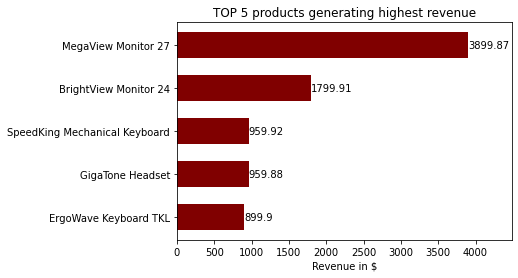

In [102]:
query = 'SELECT * FROM (SELECT TOP 5 SUM(oi.unit_price*oi.quantity_ordered) as revenue, oi.product_id, p.product_name FROM OrderItems as oi LEFT JOIN Products as p on oi.product_id = p.product_id GROUP BY oi.product_id, p.product_name ORDER BY revenue DESC) as SQ ORDER BY revenue ASC'
#the order of revenue is reversed with subquery to show greates value at the top of chart
df = pd.read_sql_query(query, engine)
ax = plt.subplot() 
ax.set_xlabel('Revenue in $') 
ax.set_title('TOP 5 products generating highest revenue')
bars = ax.barh(df['product_name'], df['revenue'], height = 0.6, color = 'maroon')
ax.bar_label(bars)
plt.margins(x=0.15)
plt.show()

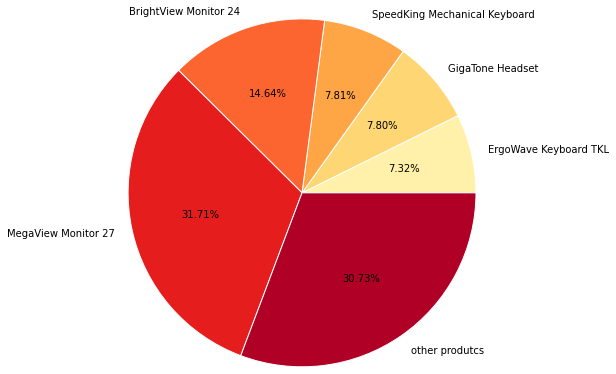

In [196]:
query = 'SELECT SUM(oi.unit_price*oi.quantity_ordered) as revenue, p.product_name FROM OrderItems as oi LEFT JOIN Products as p on oi.product_id = p.product_id WHERE product_name NOT IN (SELECT TOP 5 p.product_name FROM OrderItems as oi LEFT JOIN Products as p on oi.product_id = p.product_id GROUP BY p.product_name ORDER BY SUM(oi.unit_price*oi.quantity_ordered) DESC) GROUP BY p.product_name ORDER BY revenue DESC'
#above query returns list of products and their generated revenue that are not in the top 5
df = pd.read_sql_query(query, engine)


#calculating revenue of products except those in top 5
other_revenue = 0;
for val in df['revenue']:
    other_revenue += val;


query = 'SELECT * FROM (SELECT TOP 5 SUM(oi.unit_price*oi.quantity_ordered) as revenue, p.product_name FROM OrderItems as oi LEFT JOIN Products as p on oi.product_id = p.product_id GROUP BY oi.product_id, p.product_name ORDER BY revenue DESC) as SQ ORDER BY revenue ASC'
df = pd.read_sql_query(query, engine)
new_record = pd.DataFrame([{'revenue':other_revenue, 'product_name':'other produtcs'}])
df = pd.concat([df, new_record], ignore_index=True)


colors = plt.get_cmap('YlOrRd')(np.linspace(0.1, 0.9, len(df['revenue'])))


# plot
fig, ax = plt.subplots()
ax.pie(df['revenue'], colors=colors, radius=2, labels=df['product_name'],
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, autopct='%.2f%%')

plt.show()

<br>

### Orders data

In [82]:
query = 'SELECT COUNT(DISTINCT(order_id)) as orders_amount FROM Orders'

df = pd.read_sql_query(query, engine)
print(df[['orders_amount']].to_string(index=False))
orders_amount = df['orders_amount'][0]

 orders_amount
            95


In [81]:
query = 'SELECT COUNT(DISTINCT(order_id)) as orders_amount FROM Orders'
df = pd.read_sql_query(query, engine)
print(df)

   orders_amount
0             95


In [8]:
mean = df['total_price'].mean().round(2)
print('Average price of all orders')
print(mean)

Average price of all orders
129.46


In [9]:
print('Median price of all orders')
print(df['total_price'].median())

Median price of all orders
89.97999999999999


In [10]:
print('Mode price of all orders')
print(df['total_price'].mode())

Mode price of all orders
0    79.98
Name: total_price, dtype: float64


<br>

## Products that might need restocking based on previous month of sales and amount in stock
SELECT oi.product_id, p.product_name, SUM(oi.quantity_ordered) - p.quantity_in_stock as predicted_deficiency <br>
FROM OrderItems as oi LEFT JOIN Products as p ON oi.product_id = p.product_id <br>
GROUP BY oi.product_id, p.quantity_in_stock, p.product_name <br>
HAVING p.quantity_in_stock < SUM(oi.quantity_ordered)'<br>

In [20]:
query = 'SELECT oi.product_id, p.product_name, SUM(oi.quantity_ordered) as amount_sold, SUM(oi.quantity_ordered) - p.quantity_in_stock as predicted_deficiency FROM OrderItems as oi LEFT JOIN Products as p on oi.product_id = p.product_id GROUP BY oi.product_id, p.quantity_in_stock, p.product_name HAVING p.quantity_in_stock <= SUM(oi.quantity_ordered) ORDER BY predicted_deficiency DESC'
df = pd.read_sql_query(query, engine)
print(df)

   product_id              product_name  amount_sold  predicted_deficiency
0          10       MegaView Monitor 27           13                     6
1          11    FlexiArm Monitor Stand           10                     5
2           4     PixelPerfect Mousepad           12                     2
3           6  EcoPower Surge Protector            8                     0
4          14        LightType Keyboard            9                     0
